In [3]:
!pip install datasets
!pip install seqeval



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=9b2adf44ad055c772b57357630060a9c3a56a27360d49dd0c62951350b636c30
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from datasets import load_dataset
from seqeval.metrics import classification_report
from seqeval.scheme import IOB2
from tensorflow.keras import regularizers

# Tải dữ liệu CoNLL-2003
dataset = load_dataset("conll2003")
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

Độ dài trung bình: 14.501887329962253
Độ dài tối đa: 113


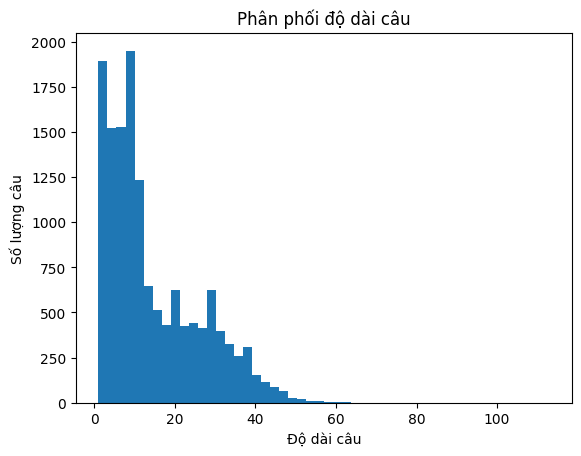

In [9]:
# Độ dài các câu trong tập huấn luyện
sentence_lengths = [len(tokens) for tokens in train_data['tokens']]

# In ra thông tin độ dài câu
print("Độ dài trung bình:", np.mean(sentence_lengths))
print("Độ dài tối đa:", np.max(sentence_lengths))

# Vẽ biểu đồ phân phối
import matplotlib.pyplot as plt
plt.hist(sentence_lengths, bins=50)
plt.title("Phân phối độ dài câu")
plt.xlabel("Độ dài câu")
plt.ylabel("Số lượng câu")
plt.show()


In [10]:
# Lấy thông tin nhãn NER
label_names = train_data.features['ner_tags'].feature.names

# Hàm chuyển đổi nhãn số thành chuỗi
def decode_tags(tags):
    return [label_names[tag] for tag in tags]

# Tokenizer để mã hóa từ
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(train_data['tokens'])

# Mã hóa các câu thành số
X_train = tokenizer.texts_to_sequences(train_data['tokens'])
X_val = tokenizer.texts_to_sequences(val_data['tokens'])
X_test = tokenizer.texts_to_sequences(test_data['tokens'])

In [11]:
# Padding các câu
max_len = 60  # Độ dài tối đa của câu
X_train = pad_sequences(X_train, maxlen=max_len, padding="post", truncating="post")
X_val = pad_sequences(X_val, maxlen=max_len, padding="post", truncating="post")
X_test = pad_sequences(X_test, maxlen=max_len, padding="post", truncating="post")

# Mã hóa nhãn và padding
y_train = pad_sequences(train_data['ner_tags'], maxlen=max_len, padding="post", truncating="post")
y_val = pad_sequences(val_data['ner_tags'], maxlen=max_len, padding="post", truncating="post")
y_test = pad_sequences(test_data['ner_tags'], maxlen=max_len, padding="post", truncating="post")

# Chuyển nhãn thành dạng one-hot encoding
num_labels = len(label_names)
y_train = to_categorical(y_train, num_classes=num_labels)
y_val = to_categorical(y_val, num_classes=num_labels)
y_test = to_categorical(y_test, num_classes=num_labels)

# Kiểm tra dữ liệu
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Ví dụ câu đầu tiên:", train_data['tokens'][0])
print("Nhãn dạng chuỗi:", decode_tags(train_data['ner_tags'][0]))

# Xây dựng mô hình RNN với Dropout
embedding_dim = 128
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(units=64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5,
                        kernel_regularizer=regularizers.l2(0.01))),
    Dropout(0.5),  # Thêm lớp Dropout để tránh overfitting
    TimeDistributed(Dense(num_labels, activation="softmax"))
])

# Compile mô hình với điều chỉnh learning rate
optimizer = Adam(learning_rate=0.001)  # Điều chỉnh learning rate
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping và ModelCheckpoint để theo dõi mô hình tốt nhất
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)

# Huấn luyện mô hình với điều chỉnh batch_size và epochs
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,  # Thử điều chỉnh batch_size
    epochs=20,  # Bạn có thể thay đổi số lượng epochs
    callbacks=[early_stopping, checkpoint]
)

X_train shape: (14041, 60)
y_train shape: (14041, 60, 9)
Ví dụ câu đầu tiên: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Nhãn dạng chuỗi: ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']
Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 65s 226ms/step - accuracy: 0.9303 - loss: 1.9066 - val_accuracy: 0.9563 - val_loss: 0.2032
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 50s 227ms/step - accuracy: 0.9596 - loss: 0.1855 - val_accuracy: 0.9563 - val_loss: 0.1755
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 80s 219ms/step - accuracy: 0.9601 - loss: 0.1552 - val_accuracy: 0.9618 - val_loss: 0.1422
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 80s 209ms/step - accuracy: 0.9648 - loss: 0.1237 - val_accuracy: 0.9663 - val_loss: 0.1226
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 83s 213ms/step - accuracy: 0.9703 - loss: 0.1025 - val_accuracy: 0.9707 - val_loss: 0.1091
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 84s 223ms/step - accuracy: 0.9744 - loss: 0.0899 - val_accuracy: 0.9720 - 

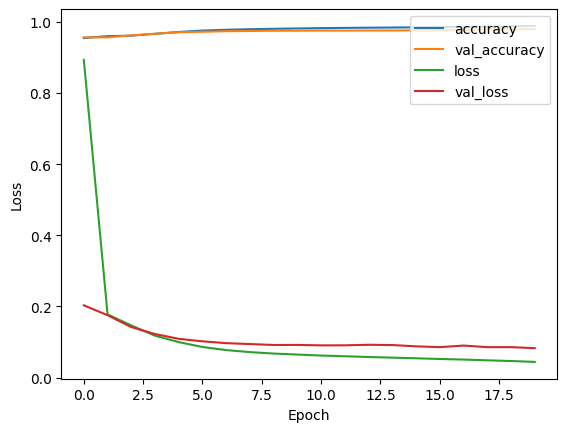

In [12]:
# Save training history to a log file
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig("accuracy_plot.png")

# Plot loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig("loss_plot.png")


In [13]:
# Đánh giá trên tập kiểm tra
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Dự đoán trên tập kiểm tra và đánh giá bằng F1-score
def decode_predictions(preds):
    return [[label_names[np.argmax(tag)] for tag in sentence] for sentence in preds]

y_pred = model.predict(X_test, verbose=1)
y_pred = decode_predictions(y_pred)
y_true = decode_predictions(y_test)

# Báo cáo F1-score
print(classification_report(y_true, y_pred, mode='strict', scheme=IOB2))

# Lưu mô hình
model.save("ner_rnn_model_conll2003.keras")
print("Mô hình đã được lưu thành công!")

108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9737 - loss: 0.0993
Test Loss: 0.09252167493104935, Test Accuracy: 0.975267767906189
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step
              precision    recall  f1-score   support

         LOC       0.65      0.59      0.62      1660
        MISC       0.73      0.45      0.56       702
         ORG       0.43      0.54      0.48      1660
         PER       0.58      0.30      0.39      1595

   micro avg       0.55      0.47      0.51      5617
   macro avg       0.60      0.47      0.51      5617
weighted avg       0.58      0.47      0.51      5617

Mô hình đã được lưu thành công!
